# Cats and Dogs Classification

## 1. Load packages

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## 2. Check the availibility of GPU

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## 3. Data Cleaning

In [3]:
# load filenames for dog and cat images
train_dog_files = np.array(glob("dogs-vs-cats-redux-kernels-edition/train/dog/*"))
train_cat_files = np.array(glob("dogs-vs-cats-redux-kernels-edition/train/cat/*"))
valid_dog_files = np.array(glob("dogs-vs-cats-redux-kernels-edition/valid/dog/*"))
valid_cat_files = np.array(glob("dogs-vs-cats-redux-kernels-edition/valid/cat/*"))
test_files = np.array(glob("dogs_vs_cats/test/*"))

# print number of images in each dataset
print('There are %d total training dog images.' % len(train_dog_files))
print('There are %d total training cat images.' % len(train_cat_files))
print('There are %d total validation dog images.' % len(valid_dog_files))
print('There are %d total validation cat images.' % len(valid_cat_files))
print('There are %d total test images.' % len(test_files))

There are 10000 total training dog images.
There are 10000 total training cat images.
There are 2500 total validation dog images.
There are 2500 total validation cat images.
There are 12500 total test images.


In [4]:
# define pretrained model used for cleaning data
resnet152_original = models.resnet152(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    resnet152_original = resnet152_original.cuda()

# convert data to a normalized torch.FloatTensor
aug_transforms = transforms.Compose([transforms.RandomRotation(30),
                                    transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])

transforms = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])])

def process_image(image):
    im = Image.open(image)
    image = transforms(im)
    return image.numpy()


def resnet152_predict(img_path, top_k=5):
    '''
    Use pre-trained ResNet-152 model to obtain indices corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Indices corresponding to ResNet-152 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *indices* of the predicted class for that image
    
    np_image = process_image(img_path)
    image = torch.from_numpy(np_image)
    image.unsqueeze_(0)
    image = image.cuda()
    resnet152_original.eval()
    with torch.no_grad():
        output = resnet152_original(image)
    x = torch.topk(output, top_k)
    
    return x[1][0].cpu().detach().numpy() # predicted array of class indices


### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, top_k=5):
    prediction = resnet152_predict(img_path, top_k)
    for class_idx in prediction:
        if ((class_idx <= 268) & (class_idx >= 151)):
            return True
        else:
            continue
    return False


### returns "True" if a cat is detected in the image stored at img_path
def cat_detector(img_path, top_k=5):
    prediction = resnet152_predict(img_path, top_k)
    for class_idx in prediction:
        if (((class_idx <= 285) & (class_idx >= 281)) | (class_idx==383) | (class_idx==387)):
            return True
        else:
            continue
    return False

In [5]:
not_dog_train = []
count = 0
for file in train_dog_files:
    if dog_detector(file, 5) == False:
        not_dog_train.append(file)
        count += 1
        print(file.split('/')[2])
print("{} dog images in training set are not detected by ResNet-152 top 5 classes.".format(count))

dog\dog.1043.jpg
dog\dog.1077.jpg
dog\dog.1194.jpg
dog\dog.1259.jpg
dog\dog.1308.jpg
dog\dog.1311.jpg
dog\dog.1625.jpg
dog\dog.1773.jpg
dog\dog.1835.jpg
dog\dog.1858.jpg
dog\dog.1895.jpg
dog\dog.2360.jpg
dog\dog.2422.jpg
dog\dog.2500.jpg
dog\dog.2542.jpg
dog\dog.2614.jpg
dog\dog.304.jpg
dog\dog.3522.jpg
dog\dog.3629.jpg
dog\dog.3822.jpg
dog\dog.3882.jpg
dog\dog.3889.jpg
dog\dog.410.jpg
dog\dog.4334.jpg
dog\dog.4367.jpg
dog\dog.4507.jpg
dog\dog.4595.jpg
dog\dog.4768.jpg
dog\dog.5099.jpg
dog\dog.5170.jpg
dog\dog.5336.jpg
dog\dog.5347.jpg
dog\dog.5529.jpg
dog\dog.5604.jpg
dog\dog.5644.jpg
dog\dog.595.jpg
dog\dog.6089.jpg
dog\dog.6243.jpg
dog\dog.6405.jpg
dog\dog.6414.jpg
dog\dog.6475.jpg
dog\dog.6685.jpg
dog\dog.6725.jpg
dog\dog.7076.jpg
dog\dog.7169.jpg
dog\dog.7265.jpg
dog\dog.7413.jpg
dog\dog.7727.jpg
dog\dog.7913.jpg
dog\dog.824.jpg
dog\dog.8457.jpg
dog\dog.8607.jpg
dog\dog.8671.jpg
dog\dog.8736.jpg
dog\dog.8898.jpg
dog\dog.9188.jpg
dog\dog.9418.jpg
dog\dog.9517.jpg
dog\dog.9628.jpg
d

In [6]:
not_dog_valid = []
count = 0
for file in valid_dog_files:
    if dog_detector(file, 5) == False:
        not_dog_valid.append(file)
        count += 1
        print(file.split('/')[2])
print("{} dog images in validation set are not detected by ResNet-152 top 5 classes.".format(count))

dog\dog.10161.jpg
dog\dog.10179.jpg
dog\dog.10190.jpg
dog\dog.10237.jpg
dog\dog.10747.jpg
dog\dog.10801.jpg
dog\dog.10900.jpg
dog\dog.10939.jpg
dog\dog.11299.jpg
dog\dog.11440.jpg
dog\dog.12148.jpg
dog\dog.12155.jpg
dog\dog.12353.jpg
dog\dog.12376.jpg
14 dog images in validation set are not detected by ResNet-152 top 5 classes.


In [7]:
not_cat_train = []
count = 0
for file in train_cat_files:
    if cat_detector(file, 10) == False:
        not_cat_train.append(file)
        count += 1
        print(file.split('/')[2])
print("{} cat images in training set are not detected by ResNet-152 top 10 classes.".format(count))

cat\cat.1004.jpg
cat\cat.1053.jpg
cat\cat.1110.jpg
cat\cat.1119.jpg
cat\cat.1234.jpg
cat\cat.124.jpg
cat\cat.1254.jpg
cat\cat.1288.jpg
cat\cat.1317.jpg
cat\cat.1359.jpg
cat\cat.1408.jpg
cat\cat.1450.jpg
cat\cat.1460.jpg
cat\cat.1485.jpg
cat\cat.1497.jpg
cat\cat.1532.jpg
cat\cat.1546.jpg
cat\cat.1608.jpg
cat\cat.1611.jpg
cat\cat.1619.jpg
cat\cat.1660.jpg
cat\cat.169.jpg
cat\cat.1741.jpg
cat\cat.1742.jpg
cat\cat.1747.jpg
cat\cat.1906.jpg
cat\cat.1928.jpg
cat\cat.1936.jpg
cat\cat.1991.jpg
cat\cat.2002.jpg
cat\cat.2150.jpg
cat\cat.2189.jpg
cat\cat.221.jpg
cat\cat.222.jpg
cat\cat.2226.jpg
cat\cat.2279.jpg
cat\cat.2337.jpg
cat\cat.2342.jpg
cat\cat.2355.jpg
cat\cat.242.jpg
cat\cat.2422.jpg
cat\cat.2429.jpg
cat\cat.2433.jpg
cat\cat.245.jpg
cat\cat.2457.jpg
cat\cat.2496.jpg
cat\cat.2520.jpg
cat\cat.26.jpg
cat\cat.2609.jpg
cat\cat.2621.jpg
cat\cat.2634.jpg
cat\cat.2663.jpg
cat\cat.2715.jpg
cat\cat.2748.jpg
cat\cat.2751.jpg
cat\cat.2753.jpg
cat\cat.2772.jpg
cat\cat.2817.jpg
cat\cat.2832.jpg
cat\c

In [8]:
not_cat_valid = []
count = 0
for file in valid_cat_files:
    if cat_detector(file, 10) == False:
        not_cat_valid.append(file)
        count += 1
        print(file.split('/')[2])
print("{} cat images in validation set are not detected by ResNet-152 top 10 classes.".format(count))

cat\cat.10029.jpg
cat\cat.10037.jpg
cat\cat.10145.jpg
cat\cat.10151.jpg
cat\cat.10209.jpg
cat\cat.10220.jpg
cat\cat.10266.jpg
cat\cat.10270.jpg
cat\cat.10276.jpg
cat\cat.10355.jpg
cat\cat.10365.jpg
cat\cat.10425.jpg
cat\cat.10441.jpg
cat\cat.10471.jpg
cat\cat.10524.jpg
cat\cat.10532.jpg
cat\cat.10536.jpg
cat\cat.10539.jpg
cat\cat.10562.jpg
cat\cat.10579.jpg
cat\cat.10712.jpg
cat\cat.10827.jpg
cat\cat.10839.jpg
cat\cat.10841.jpg
cat\cat.10864.jpg
cat\cat.10893.jpg
cat\cat.10932.jpg
cat\cat.10945.jpg
cat\cat.10946.jpg
cat\cat.11061.jpg
cat\cat.11125.jpg
cat\cat.11159.jpg
cat\cat.11184.jpg
cat\cat.11222.jpg
cat\cat.11228.jpg
cat\cat.11256.jpg
cat\cat.11281.jpg
cat\cat.11386.jpg
cat\cat.11399.jpg
cat\cat.11413.jpg
cat\cat.11416.jpg
cat\cat.11458.jpg
cat\cat.11520.jpg
cat\cat.11544.jpg
cat\cat.11565.jpg
cat\cat.11579.jpg
cat\cat.11607.jpg
cat\cat.11633.jpg
cat\cat.11661.jpg
cat\cat.11724.jpg
cat\cat.11726.jpg
cat\cat.11773.jpg
cat\cat.11777.jpg
cat\cat.11784.jpg
cat\cat.11838.jpg
cat\cat.11

## 4. Load Data

In [5]:
# define training and test data directories
data_dir = 'dogs_vs_cats/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['cat', 'dog']

# how many workers for training
num_workers = 4
# how many samples per batch to load
batch_size = 128

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=aug_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=transforms)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers,
                                           shuffle=False)
loaders = {'train': train_loader, 'valid': valid_loader}

Num training images:  19945
Num validation images:  4976


## 5. Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

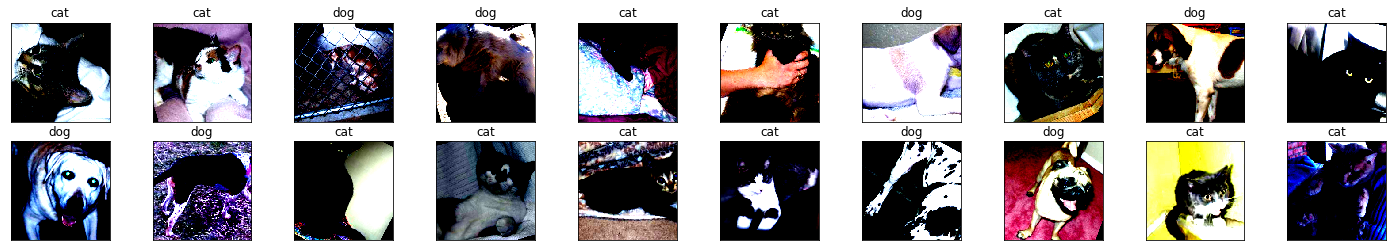

In [10]:
# visualize 20 of training images after transformation
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## 6. Define the model

In [6]:
# Load the pretrained model from pytorch
resnet152 = models.resnet152(pretrained=True)

# Freeze training for all layers
for param in resnet152.parameters():
    param.requires_grad = False

n_inputs = resnet152.fc.in_features

# add last linear layer (n_inputs -> 2 classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

resnet152.fc = last_layer

# if GPU is available, move the model to GPU
if use_cuda:
    resnet152.cuda()

resnet152

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## 7. Training

In [7]:
# train parameters for fc layer
for param in resnet152.fc.parameters():
    param.requires_grad = True
for param in resnet152.avgpool.parameters():
    param.requires_grad = True
for param in resnet152.layer4.parameters():
    param.requires_grad = True
for param in resnet152.layer3[18:].parameters():
    param.requires_grad = True
    
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
parameters = list(resnet152.fc.parameters()) + list(resnet152.avgpool.parameters()) + 
             list(resnet152.layer4.parameters()) + list(resnet152.layer3[18:].parameters())

optimizer = optim.SGD(parameters, lr=1e-6)

In [8]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, current_valid_loss_min=np.Inf):
    """returns trained model"""
    valid_loss_min = current_valid_loss_min # track change in validation loss

    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
    
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move tensors to GPU if CUDA is available
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss += loss.item()*data.size(0)
    
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
    # return trained model
    return model

In [15]:
# train the model
resnet152 = train(20, loaders, resnet152, optimizer, criterion, use_cuda, 'resnet152.pt', current_valid_loss_min=0.020764)

Epoch: 1 	Training Loss: 0.030133 	Validation Loss: 0.020336
Validation loss decreased (0.020764 --> 0.020336).  Saving model ...
Epoch: 2 	Training Loss: 0.030837 	Validation Loss: 0.020344
Epoch: 3 	Training Loss: 0.031433 	Validation Loss: 0.020690
Epoch: 4 	Training Loss: 0.028984 	Validation Loss: 0.020042
Validation loss decreased (0.020336 --> 0.020042).  Saving model ...
Epoch: 5 	Training Loss: 0.028182 	Validation Loss: 0.019891
Validation loss decreased (0.020042 --> 0.019891).  Saving model ...
Epoch: 6 	Training Loss: 0.028346 	Validation Loss: 0.020309
Epoch: 7 	Training Loss: 0.028307 	Validation Loss: 0.019819
Validation loss decreased (0.019891 --> 0.019819).  Saving model ...
Epoch: 8 	Training Loss: 0.025553 	Validation Loss: 0.020534
Epoch: 9 	Training Loss: 0.027332 	Validation Loss: 0.019631
Validation loss decreased (0.019819 --> 0.019631).  Saving model ...
Epoch: 10 	Training Loss: 0.027458 	Validation Loss: 0.020297
Epoch: 11 	Training Loss: 0.025703 	Validati

In [11]:
# train the model
resnet152 = train(20, loaders, resnet152, optimizer, criterion, use_cuda, 'resnet152.pt', current_valid_loss_min=0.017839)

Epoch: 1 	Training Loss: 0.025496 	Validation Loss: 0.018283
Epoch: 2 	Training Loss: 0.024665 	Validation Loss: 0.018909
Epoch: 3 	Training Loss: 0.023585 	Validation Loss: 0.018261
Epoch: 4 	Training Loss: 0.023652 	Validation Loss: 0.018010
Epoch: 5 	Training Loss: 0.024334 	Validation Loss: 0.018400
Epoch: 6 	Training Loss: 0.022656 	Validation Loss: 0.018224
Epoch: 7 	Training Loss: 0.021371 	Validation Loss: 0.017678
Validation loss decreased (0.017839 --> 0.017678).  Saving model ...
Epoch: 8 	Training Loss: 0.021624 	Validation Loss: 0.018426
Epoch: 9 	Training Loss: 0.020065 	Validation Loss: 0.018303
Epoch: 10 	Training Loss: 0.020264 	Validation Loss: 0.017530
Validation loss decreased (0.017678 --> 0.017530).  Saving model ...
Epoch: 11 	Training Loss: 0.020028 	Validation Loss: 0.017240
Validation loss decreased (0.017530 --> 0.017240).  Saving model ...
Epoch: 12 	Training Loss: 0.019052 	Validation Loss: 0.016730
Validation loss decreased (0.017240 --> 0.016730).  Saving

In [14]:
# train the model
resnet152 = train(20, loaders, resnet152, optimizer, criterion, use_cuda, 'resnet152.pt', current_valid_loss_min=0.016114)

Epoch: 1 	Training Loss: 0.018936 	Validation Loss: 0.018009
Epoch: 2 	Training Loss: 0.019655 	Validation Loss: 0.016306
Epoch: 3 	Training Loss: 0.016984 	Validation Loss: 0.016523
Epoch: 4 	Training Loss: 0.017727 	Validation Loss: 0.016678
Epoch: 5 	Training Loss: 0.018050 	Validation Loss: 0.016050
Validation loss decreased (0.016114 --> 0.016050).  Saving model ...
Epoch: 6 	Training Loss: 0.018357 	Validation Loss: 0.016489
Epoch: 7 	Training Loss: 0.016795 	Validation Loss: 0.016406
Epoch: 8 	Training Loss: 0.016308 	Validation Loss: 0.015771
Validation loss decreased (0.016050 --> 0.015771).  Saving model ...
Epoch: 9 	Training Loss: 0.015910 	Validation Loss: 0.016517
Epoch: 10 	Training Loss: 0.016711 	Validation Loss: 0.016623
Epoch: 11 	Training Loss: 0.016019 	Validation Loss: 0.017116
Epoch: 12 	Training Loss: 0.015622 	Validation Loss: 0.016579
Epoch: 13 	Training Loss: 0.016172 	Validation Loss: 0.015458
Validation loss decreased (0.015771 --> 0.015458).  Saving model 

In [10]:
# train the model
resnet152 = train(20, loaders, resnet152, optimizer, criterion, use_cuda, 'resnet152.pt', current_valid_loss_min=0.014898)

Epoch: 1 	Training Loss: 0.013056 	Validation Loss: 0.014432
Validation loss decreased (0.014898 --> 0.014432).  Saving model ...
Epoch: 2 	Training Loss: 0.014122 	Validation Loss: 0.014994
Epoch: 3 	Training Loss: 0.013961 	Validation Loss: 0.015434
Epoch: 4 	Training Loss: 0.013643 	Validation Loss: 0.016102
Epoch: 5 	Training Loss: 0.013778 	Validation Loss: 0.015401
Epoch: 6 	Training Loss: 0.014221 	Validation Loss: 0.016232
Epoch: 7 	Training Loss: 0.013166 	Validation Loss: 0.014663
Epoch: 8 	Training Loss: 0.013057 	Validation Loss: 0.015006
Epoch: 9 	Training Loss: 0.013976 	Validation Loss: 0.014111
Validation loss decreased (0.014432 --> 0.014111).  Saving model ...
Epoch: 10 	Training Loss: 0.012691 	Validation Loss: 0.015576
Epoch: 11 	Training Loss: 0.013055 	Validation Loss: 0.014984
Epoch: 12 	Training Loss: 0.013826 	Validation Loss: 0.015272
Epoch: 13 	Training Loss: 0.012489 	Validation Loss: 0.015646
Epoch: 14 	Training Loss: 0.012930 	Validation Loss: 0.014552
Epo

## 8. Load the model with the lowest validation loss

In [9]:
resnet152.load_state_dict(torch.load('resnet152.pt'))

## 9. Test model

In [10]:
submission = pd.read_csv('submission.csv')
submission.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [11]:
resnet152.eval()
for i in submission.index:
    num_str = str(submission.id[i])
    path = test_dir + num_str + '.jpg'
    np_image = process_image(path)
    image = torch.from_numpy(np_image)
    image.unsqueeze_(0)
    image = image.cuda()
    with torch.no_grad():
        output = resnet152(image)
    cat_score, dog_score = output[0][0].cpu().detach().numpy(), output[0][1].cpu().detach().numpy()
    prob = np.exp(dog_score)/(np.exp(cat_score) + np.exp(dog_score))
    submission.loc[i, 'label'] = prob

In [12]:
for i in submission.index:
    submission.loc[i, 'label'] = np.clip(submission.label[i], 0.005, 0.995)

In [13]:
submission.to_csv('final_submission.csv', index=False)